# **STUDENT AI** - MATH MODEL CREATION (CLASSIFICATION)

## Objectives

Create a classification model to predict Math score based on Key dataset features. Numerical variables will be grouped into bins. <br> 
Since the 3 bin classification did not yield promising results, the same steps will be repeated using the 2 bin classification.

## Inputs

Continues to assess dataset loaded in previous notebook.

## Outputs

Pipeline and .pkl file to use for predicting a students math score based on the derived calculated best feature variables.


---

## Build Pipeline for classification model to predict Math numerical target variable

The steps for a classification model are a little more involved when using a dataset with a numerical target variable

| Step |  Purpose | 
|---|---|
|Data Cleaning|Deal with missing data or wrong data - step already completed in the saved dataset|
|Discretize Numerical Target|group target variable into bins for categorization|
|Encode Categorical Features|Model algorithms can only handle numerical data. Needs to be converted first|
|Feature Scaling|Ensure all numerical data has a similar scale and is centered around zero - neccessary / improves model performance|
|Data Balancing|Classification models are affected negatively by imbalanced data. SMOTE or Undersampling needs to be performed to balance the dataset|
|Feature Smart Correlation|Determine which features are most significant and eliminate uneccessary ones - helps prevent overfitting - not neccesary|
|Feature Selection|Select which features will be used |
|Algorithm Selection|Assess best algorithm for the data set as well as the best associated Parameters and Hyperparameters|
|Model Training|Train the model on the train data and evaluate with the test set|


# Import required libraries

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Pipeline
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### libraries for custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

### Feature Balancing
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

### EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser

### packages for classification report and confusion matrix
from sklearn.metrics import make_scorer, recall_score

### Train test split
from sklearn.model_selection import train_test_split

### Packages for generating a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

### GridSearchCV
from sklearn.model_selection import GridSearchCV

print('All Libraries Loaded')

All Libraries Loaded


# Change working directory

### Set the working directory to notebook parent folder
If the output does not match, click **'clear all outputs'** and then **'restart'** the notebook. 
Then run cells from top to bottom.

In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('If correct, Active Directory should read: /workspace/student-AI')
print(f"Active Directory: {current_dir}")

If correct, Active Directory should read: /workspace/student-AI
Active Directory: /workspace/student-AI


### Load cleaned dataset

In [3]:
df = pd.read_csv(f"outputs/dataset/Expanded_data_with_more_features_clean.csv")
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,group C,bachelor's degree,standard,none,married,regularly,yes,3,< 5,71,71,74
1,female,group C,some college,standard,none,married,sometimes,yes,0,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0,5 - 10,76,78,75


nrSiblings is treated as a numerical variable. As I determined previously it has no bearing on the target variables, so I will drop it rather than convert to categorical. The other variables previously identified in the EDA as having not much impact, I will keep in, as the Feature Selection step did not suggest to eliminate any.

In [13]:
# df['NrSiblings'] = df['NrSiblings'].astype(str)
# 'ParentMaritalStatus', 'PracticeSport','IsFirstChild','NrSiblings','WklyStudyHours'
df_math = df.drop(['ReadingScore', 'WritingScore','Gender', 'TestPrep','NrSiblings','ParentMaritalStatus', 'PracticeSport','IsFirstChild','NrSiblings','WklyStudyHours'], axis=1)
df_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   EthnicGroup  30641 non-null  object
 1   ParentEduc   30641 non-null  object
 2   LunchType    30641 non-null  object
 3   MathScore    30641 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 957.7+ KB


### Categorize Data set Target Math Variable

In [15]:
class CustomDiscretizer(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to automatically generate categorical bins from a numerical variable
    Arguments are a pandas dataframe, the number of bins and the column(s) to discretize
    bins are sized based on the column mean value and standard deviation
    2 bins are spit at the mean
    3 bins are split +- 1/2 the SD
    5 bins are split at the  mean with 1*SD and 2*Sd as the cutoff
    If wrong bin argument is given, defaults to 5
    No column arg = use all columns (default)
    """
    def __init__(self, n_bins=3, columns=None):
        if n_bins not in [2, 3, 5]:
            print("Error: n_bins must be : [2, 3 or 5]. Setting 5 as default.")
            self.n_bins = 5  # Default
        else:
            self.n_bins = n_bins
        self.columns = columns
    
    def fit(self, X, y=None):
        # not needed
        return self
    
    def transform(self, X):
        # Ensure X is a DataFrame
        X_transformed = X.copy()
        # If columns param is None, apply to all columns
        columns_to_discretize = self.columns if self.columns is not None else X.columns
        
        for column in columns_to_discretize:
            if column in X.columns:  # Check column exists
                mean = X[column].mean()
                std = X[column].std()
                min_val = X[column].min()
                max_val = X[column].max()

                if self.n_bins == 5:
                    bins = [min_val-1, mean - 2*std, mean - std, mean, mean + std, max_val+1]
                    labels = [0, 1, 2, 3, 4]
                
                elif self.n_bins == 3:
                    bins = [min_val-1, mean - std/2, mean + std/2, max_val+1]
                    labels = [0, 1, 2]
                
                elif self.n_bins == 2:
                    bins = [min_val-1, mean, max_val+1]
                    labels = [0, 1]

                X_transformed[column] = pd.cut(X[column], bins=bins, labels=labels, include_lowest=True)
            else:
                # If the column is not in the DataFrame,  raise an error or warn
                print(f"Column {column} not found in DataFrame!")
        
        return X_transformed

In [16]:
discretizer = CustomDiscretizer(n_bins=2, columns=['MathScore'])
df_transformed = discretizer.fit_transform(df_math)
df_transformed.head()


,EthnicGroup,ParentEduc,LunchType,MathScore
0,group C,bachelor's degree,standard,1
1,group C,some college,standard,1
2,group B,master's degree,standard,1
3,group A,associate's degree,free/reduced,0
4,group C,some college,standard,1


### Split Data Set into Train and Test sets

In [17]:
 =math_train_features, math_test_features, math_train_scores, math_test_scores train_test_split(
    df_transformed.drop(['MathScore'], axis=1),
    df_transformed['MathScore'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", math_train_features.shape, math_train_scores.shape, "\n* Test set:",  math_test_features.shape, math_test_scores.shape)

* Train set: (24512, 3) (24512,) 
* Test set: (6129, 3) (6129,)


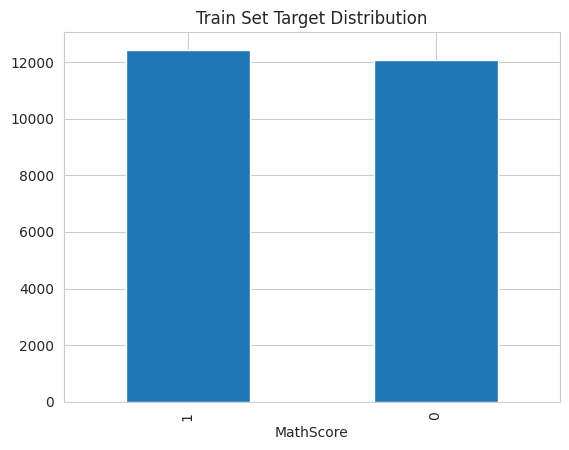

In [18]:
sns.set_style("whitegrid")
math_train_scores.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [42]:
feature_set = ['LunchType','EthnicGroup','ParentEduc']

In [43]:
def PipelineOptimization(model):
    pipeline_base = ImbPipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary', 
            variables=feature_set)),

        ("model", model),

    ])

    return pipeline_base

### Define best algorithm and hyperparameters

In [22]:
selected_model = {"AdaBoostClassifier": AdaBoostClassifier(random_state=0),}
selected_model_parameters = {"AdaBoostClassifier": {
    'model__n_estimators': [25],
    'model__learning_rate':[2],
    }
  }

selected_model_parameters

{'AdaBoostClassifier': {'model__n_estimators': [25],
  'model__learning_rate': [2]}}

### Final GridSearch CV

In [24]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

In [25]:
math_model = HyperparameterOptimizationSearch(models=selected_model, parameters=selected_model_parameters)
math_model.fit(math_train_features, math_train_scores,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)



Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


### Custom Confusion Matrix Function from CI Customer Churn Course

In [7]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")

  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")

def clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(math_train_features, math_train_scores, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(math_test_features, math_test_scores, pipeline, label_map)

In [28]:
grid_search_summary_final, grid_search_pipelines_final = math_model.score_summary(sort_by='mean_score')
grid_search_summary_final

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__learning_rate,model__n_estimators
0,AdaBoostClassifier,0.486755,0.494207,0.502689,0.005574,2,25


In [29]:
final_model = grid_search_summary_final.iloc[0,0]
final_model

'AdaBoostClassifier'

In [30]:
pipeline_clf_final = grid_search_pipelines_final[final_model].best_estimator_
pipeline_clf_final

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['LunchType', 'EthnicGroup',
                                           'ParentEduc'])),
                ('model',
                 AdaBoostClassifier(learning_rate=2, n_estimators=25,
                                    random_state=0))])

* These are the 3 most important features in descending order. The model was trained on them: 
['LunchType', 'EthnicGroup', 'ParentEduc']


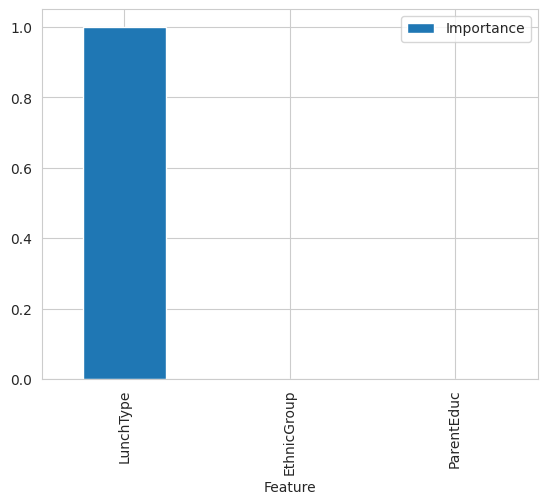

In [32]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_final.steps[:data_cleaning_feat_eng_steps])
                                        .transform(math_train_features)
                                        .columns)

# create DataFrame to display feature importance
df_feature_importance_final = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': pipeline_clf_final['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features_final = df_feature_importance_final['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_final)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_final}")

df_feature_importance_final.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [34]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")

  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")

def clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(math_train_features, math_train_scores, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(math_test_features, math_test_scores, pipeline, label_map)

In [39]:
label_map = ['Below Average','Above Average']

In [40]:
clf_performance(math_train_features, math_train_scores, math_test_features, math_test_scores, pipeline_clf_final, label_map )


#### Train Set #### 

---  Confusion Matrix  ---
                         Actual Below Average Actual Above Average
Prediction Below Average                 5972                 2595
Prediction Above Average                 6112                 9833


---  Classification Report  ---
               precision    recall  f1-score   support

Below Average       0.70      0.49      0.58     12084
Above Average       0.62      0.79      0.69     12428

     accuracy                           0.64     24512
    macro avg       0.66      0.64      0.64     24512
 weighted avg       0.66      0.64      0.64     24512
 

#### Test Set ####

---  Confusion Matrix  ---
                         Actual Below Average Actual Above Average
Prediction Below Average                 1517                  652
Prediction Above Average                 1555                 2405


---  Classification Report  ---
               precision    recall  f1-score   support

Below Average       0.70      0.49      0.5

## Create Final Model Files

In [44]:
version = 'v1'
file_path = f'outputs/models/math/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

#### Check variable content before saving

In [48]:
# math_train_features.head()
# math_train_scores.head()
# math_test_features.head()
# math_test_scores.head()

28031    1
14300    1
21304    0
19953    1
28702    0
Name: MathScore, dtype: category
Categories (2, int64): [0 < 1]

### Set Model Version and destination

In [85]:
version = "v1"
target = "math"

file_path = f"outputs/models/{target}/{version}"
file_path

'outputs/models/math/v1'

### Output files

*** Removing previous files  ***
outputs/models/reading/v1/math-train-features.csv does not exist
outputs/models/reading/v1/math-train-scores.csv does not exist
outputs/models/reading/v1/math-test-features.csv does not exist
outputs/models/reading/v1/math-test-scores.csv does not exist
outputs/models/reading/v1/math-model.pkl does not exist
outputs/models/reading/v1/math-labels.pkl does not exist
outputs/models/reading/v1/math-feature-importance.png does not exist

*** Creating files in: outputs/models/reading/v1 ***
math-train-features.csv created
math-train-scores.csv created
math-test-features.csv created
math-test-scores.csv created
math_model.pkl created
math_labels created


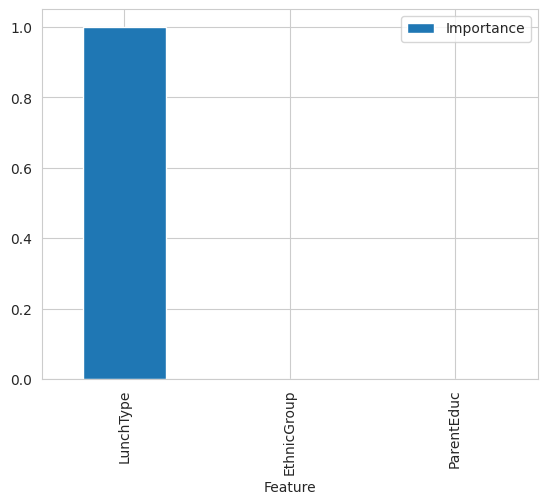

In [84]:
# Define the complete path for each file
math_train_features_path = os.path.join(file_path, "math-train-features.csv")
math_train_scores_path = os.path.join(file_path, "math-train-scores.csv")
math_test_features_path = os.path.join(file_path, "math-test-features.csv")
math_test_scores_path = os.path.join(file_path, "math-test-scores.csv")
model_path = os.path.join(file_path, "math-model.pkl")
labels_path = os.path.join(file_path, "math-labels.pkl")
features_importance_path = os.path.join(file_path, "math-feature-importance.png")

# Ensure the directory exists
os.makedirs(file_path, exist_ok=True)

# Remove files if they exist
print(f'*** Removing previous files  ***')
for file in [math_train_features_path, math_train_scores_path, math_test_features_path, math_test_scores_path, model_path, labels_path, features_importance_path]:
    if os.path.exists(file):
        os.remove(file)
        print(f"{file} removed")
    else:
        print(f"{file} does not exist")

# Save .csv files
print('')
print(f'*** Creating files in: {file_path} ***')

math_train_features.to_csv(math_train_features_path, index=False)
print(f'math-train-features.csv created')

math_train_scores.to_csv(math_train_scores_path, index=False)
print(f'math-train-scores.csv created')

math_test_features.to_csv(math_test_features_path, index=False)
print(f'math-test-features.csv created')

math_test_scores.to_csv(math_test_scores_path, index=False)
print(f'math-test-scores.csv created')

# Save .pkl model files
joblib.dump(value=pipeline_clf_final, filename=f"{file_path}/math-model.pkl")
print(f'math_model.pkl created')

joblib.dump(value=label_map, filename=f"{file_path}/math-labels.pkl")
print(f'math_labels created')

# Save features plot image
df_feature_importance_final.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/math-feature-importance.png', bbox_inches='tight')

